I use colab for training my model, so I transferred all needed functions here

In [ ]:
!pip install datasets==2.11
!pip install datasets transformers[sentencepiece] sacrebleu
!pip install transformers[torch]
!pip install accelerate -U
!pip install rouge_score
!pip install evaluate

In [3]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
import spacy
import warnings
warnings.warn("ignore")


def create_dataframe(zip_file_path):
    # check if zip file exists
    if not os.path.exists(zip_file_path):
        print(f"zip file '{zip_file_path}' does not exist.")
        return None

    # extract zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all files in the ZIP archive to a directory
        extraction_path = "./tmp_extraction"
        zip_ref.extractall(extraction_path)

    # find .tsv file
    tsv_file = None
    for root, dirs, files in os.walk(extraction_path):
        for file in files:
            if file.endswith(".tsv"):
                tsv_file = os.path.join(root, file)
                break

    if tsv_file is None:
        print("No .tsv file found in the extracted ZIP archive.")
        return None

    # create pandas DataFrame
    try:
        df = pd.read_csv(tsv_file, delimiter='\t')
        return df
    except Exception as e:
        print(f"Error while creating DataFrame: {str(e)}")
        return None
    finally:
        # remove the temporary extraction directory
        if os.path.exists(extraction_path):
            for root, dirs, files in os.walk(extraction_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    os.remove(file_path)
            os.rmdir(extraction_path)


def create_new_columns(dataset):
    # create new columns
    # dataset['toxic'] = [''] * dataset.shape[0]
    # dataset['nontoxic'] = [''] * dataset.shape[0]
    # dataset['toxic_tox'] = [''] * dataset.shape[0]
    # dataset['nontoxic_tox'] = [''] * dataset.shape[0]

    # create the 'toxic' and 'nontoxic' columns
    dataset['toxic'] = dataset.apply(lambda row: row['reference'] if row['ref_tox'] > row['trn_tox'] else row['translation'], axis=1)
    dataset['nontoxic'] = dataset.apply(lambda row: row['translation'] if row['ref_tox'] > row['trn_tox'] else row['reference'], axis=1)

    # create the 'toxic_tox' and 'nontoxic_tox' columns
    dataset['toxic_tox'] = dataset.apply(lambda row: row['ref_tox'] if row['ref_tox'] > row['trn_tox'] else row['trn_tox'], axis=1)
    dataset['nontoxic_tox'] = dataset.apply(lambda row: row['trn_tox'] if row['ref_tox'] > row['trn_tox'] else row['ref_tox'], axis=1)

    # drop unuseful columns
    dataset = dataset.drop(columns=['reference', 'translation', 'similarity', 'lenght_diff', 'ref_tox', 'trn_tox'])

    return dataset
    # return dataset['toxic'].tolist(), dataset['nontoxic'].tolist()


def remove_unuseful_data(dataset):
    # toxic sentences > 0.75 of toxic_tox: 0.9243254750535241
    dataset = dataset[dataset['toxic_tox'] > 0.75]

    # detoxed sentences < 0.25 of nontoxic_tox: 0.959344176040237
    dataset = dataset[dataset['nontoxic_tox'] < 0.25]

    return dataset


def get_sentences(dataset):
    # toxic and detoxed sentences
    return dataset['toxic'].tolist(), dataset['nontoxic'].tolist()


def split_train_test(toxic, nontoxic, path):
    toxic_train, toxic_test, nontoxic_train, nontoxic_test = train_test_split(
        toxic,
        nontoxic,
        test_size=0.25,
        random_state=42,
    )

    with open(os.path.join(path, 'toxic_train'), "w", encoding="UTF-8") as file:
        file.write("\n".join(toxic_train))
    with open(os.path.join(path, 'toxic_test'), "w", encoding="UTF-8") as file:
        file.write("\n".join(toxic_test))
    with open(os.path.join(path, 'nontoxic_train'), "w", encoding="UTF-8") as file:
        file.write("\n".join(nontoxic_train))
    with open(os.path.join(path, 'nontoxic_test'), "w", encoding="UTF-8") as file:
        file.write("\n".join(nontoxic_test))

def save_csv(dataset):
    dataset.to_csv("converted.csv")

def get_dict():
    return load_dataset("csv", data_files="converted.csv")

<ipython-input-3-8c4f2d1d18af>:9: UserWarning: ignore
  warnings.warn("ignore")


In [4]:
from datasets import load_dataset, load_metric, list_metrics
import pandas as pd
import evaluate

print(list_metrics())

<ipython-input-4-aa800e427431>:5: FutureWarning: list_metrics is deprecated and will be removed in the next major version of datasets. Use 'evaluate.list_evaluation_modules' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  print(list_metrics())


['accuracy', 'bertscore', 'bleu', 'bleurt', 'brier_score', 'cer', 'character', 'charcut_mt', 'chrf', 'code_eval', 'comet', 'competition_math', 'coval', 'cuad', 'exact_match', 'f1', 'frugalscore', 'glue', 'google_bleu', 'indic_glue', 'mae', 'mahalanobis', 'mape', 'mase', 'matthews_correlation', 'mauve', 'mean_iou', 'meteor', 'mse', 'nist_mt', 'pearsonr', 'perplexity', 'poseval', 'precision', 'r_squared', 'recall', 'rl_reliability', 'roc_auc', 'rouge', 'sacrebleu', 'sari', 'seqeval', 'smape', 'spearmanr', 'squad', 'squad_v2', 'super_glue', 'ter', 'trec_eval', 'wer', 'wiki_split', 'xnli', 'xtreme_s', 'AlhitawiMohammed22/CER_Hu-Evaluation-Metrics', 'BucketHeadP65/confusion_matrix', 'BucketHeadP65/roc_curve', 'DarrenChensformer/eval_keyphrase', 'DarrenChensformer/relation_extraction', 'Drunper/metrica_tesi', 'Felipehonorato/eer', 'He-Xingwei/sari_metric', 'Ikala-allen/relation_extraction', 'JP-SystemsX/nDCG', 'Josh98/nl2bash_m', 'Muennighoff/code_eval_octopack', 'NCSOFT/harim_plus', 'Natooz

In [5]:
bleu = load_metric("sacrebleu")
ter = load_metric("ter")
rouge = evaluate.load("rouge")

<ipython-input-5-20b8eac90747>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu = load_metric("sacrebleu")


In [6]:
dataset = create_dataframe("drive/MyDrive/filtered_paranmt.zip")

In [7]:
dataset = create_new_columns(dataset)
dataset = remove_unuseful_data(dataset)

In [8]:
save_csv(dataset)

In [9]:
dataset_dict = load_dataset("csv", data_files="converted.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a887467f7afc7c6d/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'toxic', 'nontoxic', 'toxic_tox', 'nontoxic_tox'],
        num_rows: 510564
    })
})

In [11]:
from transformers import AutoTokenizer

def tokenize(dataset, model_checkpoint="t5-base"):
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    max_input_length = 80
    max_target_length = 80
    prefix = ""

    inputs = [prefix + ex for ex in dataset["toxic"]]
    targets = [ex for ex in dataset["nontoxic"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [12]:
tokenize(dataset_dict['train'])

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` 

In [13]:
tokenized_datasets = dataset_dict.map(tokenize, batched=True)

Map:   0%|          | 0/510564 [00:00<?, ? examples/s]

In [14]:
model_checkpoint = "t5-base"

In [15]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [16]:
batch_size = 20
model_name = model_checkpoint.split("/")[-1]
toxic_str = "toxic"
nontoxic_str = "nontoxic"
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{toxic_str}-to-{nontoxic_str}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=5,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
    report_to="none",
    # save_steps = 500,
    # eval_steps=500,
    # logging_steps=100,
)

In [17]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [18]:
import gc
import torch

def cleanup():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()

cleanup()

In [19]:
import numpy as np

metrics = []

def compute_metrics(eval_preds):
    global metrics
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    ter_score = ter.compute(predictions=decoded_preds, references=decoded_labels)
    rouge_score = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": bleu_score["score"]}
    result["ter"] = ter_score["score"]
    result["rouge1"] = rouge_score["rouge1"]
    result["rouge2"] = rouge_score["rouge2"]

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    metrics.append(result)
    cleanup()
    return result

In [20]:
splitted_dataset = tokenized_datasets["train"].select(range(10000)).train_test_split(test_size=0.1)

In [21]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'toxic', 'nontoxic', 'toxic_tox', 'nontoxic_tox', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 9000
    })
    test: Dataset({
        features: ['Unnamed: 0.1', 'Unnamed: 0', 'toxic', 'nontoxic', 'toxic_tox', 'nontoxic_tox', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1000
    })
})

In [22]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=splitted_dataset["train"],
    eval_dataset=splitted_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [23]:
cleanup()

In [24]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Bleu,Ter,Rouge1,Rouge2,Gen Len
1,No log,1.850996,20.037716,67.091057,0.544950,0.309202,13.421000
2,2.083400,1.801413,20.907699,66.510491,0.548973,0.315688,13.401000
3,1.882500,1.778561,21.386054,66.612345,0.548941,0.314419,13.430000
4,1.797100,1.765550,21.499584,66.541047,0.550419,0.316203,13.364000
5,1.780500,1.761807,21.534267,66.561418,0.550374,0.316638,13.359000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=2250, training_loss=1.8729180772569445, metrics={'train_runtime': 862.2773, 'train_samples_per_second': 52.187, 'train_steps_per_second': 2.609, 'total_flos': 2256355496448000.0, 'train_loss': 1.8729180772569445, 'epoch': 5.0})

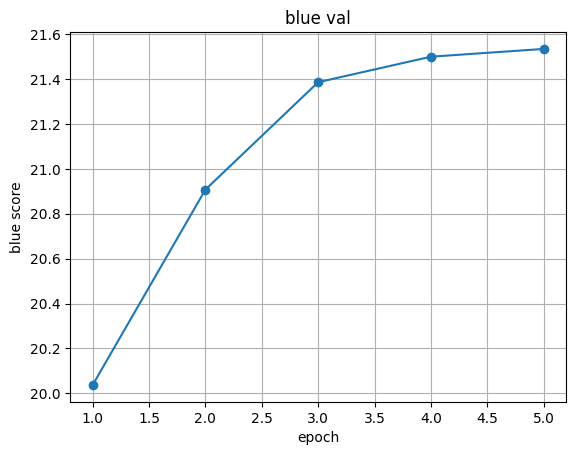

In [25]:
import matplotlib.pyplot as plt

bleu_scores = []
for i in range(len(metrics)):
    bleu_scores.append(metrics[i]["bleu"])

# epochs
indices = range(1, len(bleu_scores) + 1)

plt.plot(indices, bleu_scores, marker='o', linestyle='-')
plt.title('blue val')
plt.xlabel('epoch')
plt.ylabel('blue score')
plt.grid(True)

plt.show()

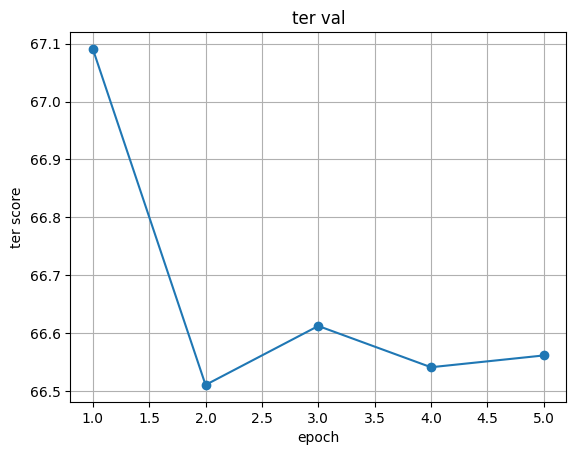

In [26]:
import matplotlib.pyplot as plt

ter_scores = []
for i in range(len(metrics)):
    ter_scores.append(metrics[i]["ter"])

# epochs
indices = range(1, len(ter_scores) + 1)

plt.plot(indices, ter_scores, marker='o', linestyle='-')
plt.title('ter val')
plt.xlabel('epoch')
plt.ylabel('ter score')
plt.grid(True)

plt.show()

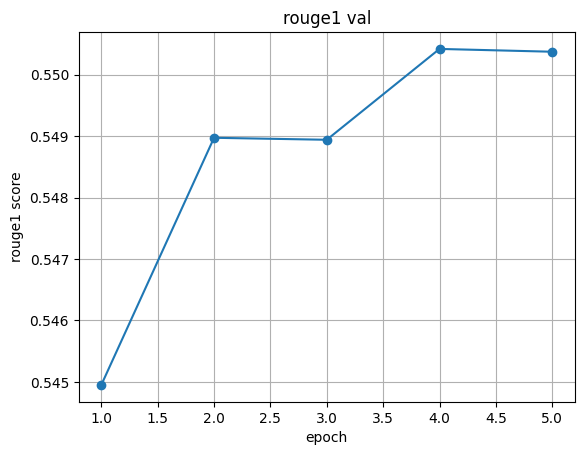

In [27]:
import matplotlib.pyplot as plt

rouge1_scores = []
for i in range(len(metrics)):
    rouge1_scores.append(metrics[i]["rouge1"])

# epochs
indices = range(1, len(rouge1_scores) + 1)

plt.plot(indices, rouge1_scores, marker='o', linestyle='-')
plt.title('rouge1 val')
plt.xlabel('epoch')
plt.ylabel('rouge1 score')
plt.grid(True)

plt.show()

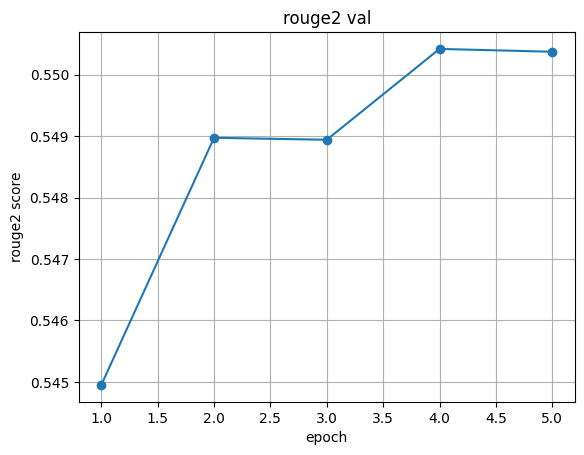

In [28]:
import matplotlib.pyplot as plt

rouge2_scores = []
for i in range(len(metrics)):
    rouge2_scores.append(metrics[i]["rouge2"])

# epochs
indices = range(1, len(rouge2_scores) + 1)

plt.plot(indices, rouge1_scores, marker='o', linestyle='-')
plt.title('rouge2 val')
plt.xlabel('epoch')
plt.ylabel('rouge2 score')
plt.grid(True)

plt.show()

In [29]:
metrics[0]

{'bleu': 20.037716477240828,
 'ter': 67.09105724180078,
 'rouge1': 0.5449499651464118,
 'rouge2': 0.3092018171072006,
 'gen_len': 13.421}

In [30]:
trainer.save_model('drive/MyDrive/best_t5_base')

In [31]:
predictions, labels, metrics = trainer.predict(splitted_dataset["test"], metric_key_prefix="predict")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [32]:
metrics

{'predict_loss': 1.761806607246399,
 'predict_bleu': 21.534267356163504,
 'predict_ter': 66.56141780403341,
 'predict_rouge1': 0.5503735893056503,
 'predict_rouge2': 0.3166376639001892,
 'predict_gen_len': 13.359,
 'predict_runtime': 32.285,
 'predict_samples_per_second': 30.974,
 'predict_steps_per_second': 1.549}

In [33]:
my_predictions = tokenizer.batch_decode(
                    predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True
                )

In [38]:
splitted_dataset["test"]["toxic"][:10]

["Your body dies right out from under you... ...and the next thing you know, you're just a pile of ash!",
 "my mom was the kind of person who will kill you if you're not careful.",
 'you want to work with my monster brother?',
 'I should have hit him years ago.',
 'You, my imbecilic commissar!',
 "you're old enough that I don't have to give you a lecture on pregnancy and genital diseases.",
 "you'd probably want me to buy you some chocolates and flowers... and whispered some pretty rubbish.",
 'I hate it when they shit on my window.',
 "Have you seen the shit they're saying about you on the Internet?",
 "You've got about 20 minutes before you bleed to death."]

In [39]:
my_predictions[:10]

["your body dies right out of under you... and the next thing you know, you'",
 "My mom was the kind of person who would kill you if you didn't take care",
 'You want to work with my monster brother?',
 'I should have hit him years ago.',
 'you, my imbecilic commissar!',
 "You're old enough to not have to give you a lecture on pregnancy and gen",
 "You'd probably want me to buy you some chocolates and flowers... and whispered",
 'I hate it when they hit my window.',
 "have you seen what they're saying about you on the Internet?",
 'you have about 20 minutes before you die.']